# 3.9. Логистическая регрессия. Практика

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах Adult Income и сделаем необходимую предобработку.

In [4]:
adult = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [5]:
# Описание датасета

with open('./data/adult.data', 'r') as f:
    names = f.read()
    print(names)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


In [33]:
adult['native-country'].replace('United-States', 'other')

0         United-States
1         United-States
2         United-States
3         United-States
4                  Cuba
              ...      
32556     United-States
32557     United-States
32558     United-States
32559     United-States
32560     United-States
Name: native-country, Length: 32561, dtype: object

In [36]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [37]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

In [38]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [45]:
#Подготовка данных

def prepare_adult():
    adult = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X,y



In [46]:
X, y = prepare_adult()


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [49]:
#Реализуем функцию sigmoid и функцию, вычисляющую градиент бинарной кросс-энтропии:
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta



In [52]:

def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')



def train_validate(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
    y_pred = sigmoid(X_valid, theta) > 0.5
    print_logisitc_metrics(y_valid, y_pred)
    return theta

    

In [53]:
#Сделаем предсказания на тренировочной выборке и посчитаем значение метрики  и  :
theta = train_validate(X, y)
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)



acc = 0.85 F1-score = 0.66
acc = 0.85 F1-score = 0.65


# Задание 3.9.1

2.0/2.0 points (graded)
Постройте модель логистической регрессии при помощи sklearn. Используйте параметры по умолчанию, обучите на всей выборке и посчитайте F1 score.

Ответ округлите до сотых, пример ввода: 0.55

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [59]:
X, y = prepare_adult()
logr = LogisticRegression(random_state=1)
clf = logr.fit(X, y)
y_pred = clf.predict(X)
f1_score(y, y_pred, zero_division=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6616594131686088

### ответ 0,66

# Задание 3.9.2

3.0/3.0 points (graded)
Посчитайте confusion matrix для классификатора из задачи 3.9.1. Для получения матрицы можно воспользоваться методом sklearn.metrics.confusion_matrix(y_true, y_pred), либо посчитать каждый элемент вручную.

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
confusion_matrix(y, y_pred)

array([[23028,  1692],
       [ 3128,  4713]])

### ответ 23030, 1690, 3124, 4717

# Задание 3.9.3

2.0/2.0 points (graded)
Постройте ROC-кривую и посчитайте  для классификатора из задачи 3.9.1.
Ответ округлите до сотых, укажите через точку:

In [63]:
from matplotlib import pyplot as plt

In [64]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

In [ ]:
def train_validate(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    

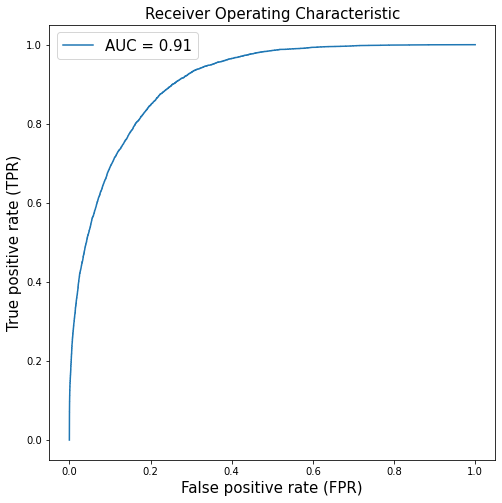

In [78]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = clf.predict_proba(X)[:, 1]
clf.classes_
calc_and_plot_roc(y, y_pred_proba)

### ответ 0,91

# Задание 3.9.4

2.0/2.0 points (graded)
Постройте модель логистической регрессии при помощи sklearn без регуляризации. Чему равен ?

Ответ округлите до сотых, пример ввода: 0.55

In [79]:
X, y = prepare_adult()
logr_nonreg = LogisticRegression(random_state=1, C=100)
clf = logr_nonreg.fit(X, y)
y_pred = clf.predict(X)
f1_score(y, y_pred, zero_division=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6618997546442341

### ответ 0,66

# Задание 3.9.5

2.0/2.0 points (graded)
Переберите коэффициенты -регуляризации от  до  с шагом  и определите, на каком из них модель логистической регрессии из sklearn даёт наибольший  .

Ответ округлите до сотых. Пример ввода: 5.55.

In [88]:
coeff_array = [round(1/m, 2) for m in range(1,101)]
f1_array = []
for coeff in coeff_array:
    logr_nonreg = LogisticRegression(penalty='l2',C=coeff)
    clf = logr_nonreg.fit(X, y)
    y_pred = clf.predict(X)
    f1 = f1_score(y, y_pred, zero_division=1)
    f1_array.append(f1)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [101]:
#вариант когда С=кофф от 0,01 до 1
max_c = 0
max_f1 = 0
f1_array = []
coeff_array = []
for m in range(1,101):
    coeff = round(m/100, 2)
    logr_nonreg = LogisticRegression(penalty='l2',C=coeff, max_iter=1000)
    clf = logr_nonreg.fit(X, y)
    y_pred = clf.predict(X)
    f1 = f1_score(y, y_pred, zero_division=1)
    f1_array.append(f1)
    coeff_array.append(coeff)
    if max_f1 < f1:
        max_c = coeff
        max_f1 = f1
print(f'maximal f1 is {max_f1} with {max_c} coeff')

maximal f1 is 0.6619876473891072 with 0.91 coeff


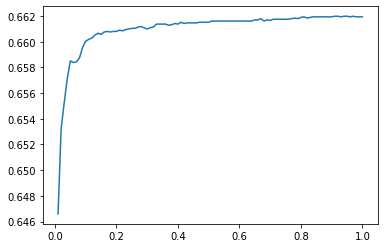

In [102]:
plt.plot(coeff_array, f1_array, label=f'max F1 = {max(f1_array)}')

In [103]:
#вариант когда С=1/кофф от 0,01 до 1
max_c = 0
max_f1 = 0
f1_array = []
coeff_array = []
for m in range(1,101):
    coeff = round(m/100, 2)
    logr_nonreg = LogisticRegression(penalty='l2',C=(1/coeff), max_iter=800)
    clf = logr_nonreg.fit(X, y)
    y_pred = clf.predict(X)
    f1 = f1_score(y, y_pred, zero_division=1)
    f1_array.append(f1)
    coeff_array.append(coeff)
    if max_f1 < f1:
        max_c = coeff
        max_f1 = f1
print(f'maximal f1 is {max_f1} with {max_c} coeff')

maximal f1 is 0.662128973405375 with 0.74 coeff


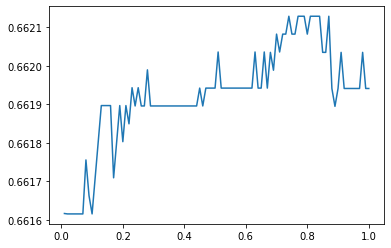

In [104]:
plt.plot(coeff_array, f1_array, label=f'max F1 = {max(f1_array)}')

### ответ 0,65 (ошибка )

# Задание 3.9.6

2.0/2.0 points (graded)
Замените в столбце native-country страны, у которых меньше ста записей на other, поменяйте эту колонку на dummy-переменные, обучите классификатор на всей выборке и посчитайте F1-score.

Ответ округлите до сотых, пример ввода: 0.55

In [245]:
def prepare_adult_new():
    adult2 = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    # Избавиться от лишних признаков
    #adult.drop(['native-country'], axis=1, inplace=True)
    #выявляем страны с менее 100 данных
    excluded_countries = adult2['native-country'].value_counts()[adult2['native-country'].value_counts()<100].index
    #заменяем эти страны на other
    adult2.loc[(adult2['native-country'].isin(excluded_countries)), 'native-country'] = 'Other'
    # Сконвертировать целевой столбец в бинарные значения
    adult2['salary'] = (adult2['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult2 = pd.get_dummies(adult2, columns=['workclass', 'education', 'native-country', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult2[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult2.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult2[list(set(adult.columns) - set(['salary']))].values
    y = adult2['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X,y



In [246]:
#Подготовка данных

def prepare_adult():
    adult = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X,y



In [247]:
X, y = prepare_adult_new()

In [248]:
logreg = LogisticRegression(max_iter=800)
clf = logreg.fit(X, y)
y_pred = clf.predict(X)
f1 = f1_score(y, y_pred, zero_division=1)
print(f'f1 coef is {f1}')

f1 coef is 0.6619411888553584


### ответ 0,66

# Задание 3.9.7

2.0/2.0 points (graded)
Провалидируйте логистическую регрессию из sklearn на 5-fold кросс-валидации. В логистической регрессии надо выставить random_state=42. Какой получился средний ?

Ответ округлите до сотых, пример ввода: 0.55

In [224]:
def prepare_adult_new():
    adult2 = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    # Избавиться от лишних признаков
    #adult.drop(['native-country'], axis=1, inplace=True)
    #выявляем страны с менее 100 данных
    excluded_countries = adult2['native-country'].value_counts()[adult2['native-country'].value_counts()<100].index
    #заменяем эти страны на other
    adult2.loc[(adult2['native-country'].isin(excluded_countries)), 'native-country'] = 'Other'
    # Сконвертировать целевой столбец в бинарные значения
    adult2['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult2 = pd.get_dummies(adult2, columns=['workclass', 'education', 'native-country', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult2[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult2.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult2[list(set(adult.columns) - set(['salary']))].values
    y = adult2['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X,y



In [230]:
#Подготовка данных

def prepare_adult():
    adult = pd.read_csv('data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X,y



In [237]:
X, y = prepare_adult()

In [236]:
adult2['native-country'].value_counts()

 United-States    29136
Other              1426
 Mexico             642
 ?                  581
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
Name: native-country, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [249]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [250]:
#cv = KFold(n_splits=5)
model = LogisticRegression(random_state=42)
scores = cross_val_score(model, X, y, scoring='f1', cv=5, n_jobs=-1)

In [251]:
scores.mean()

0.6597442299719629

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [241]:
scores = cross_val_score(model, X, y, scoring='f1_micro', cv=5, n_jobs=-1)
scores.mean()

0.8510489463333775

In [242]:
scores = cross_val_score(model, X, y, scoring='f1_macro', cv=5, n_jobs=-1)
scores.mean()

0.7821991164330996

In [243]:
scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=5, n_jobs=-1)
scores.mean()

0.8456771824909859

### ответ 0,67 (не знаю откуда ошибка)